In [1]:
import torch
import torch.nn as nn

# This demo uses images as example to try how WGAN works

In [2]:
# Build Critic
# Assume images size is 32 * 32


class Critic(nn.Module):
    
    def __init__(self, image_channels, features):
        super(Critic, self).__init__()
        self.feature_dim = features
        self.conv_block = nn.Sequential(
            nn.Conv2d(image_channels, features, 5, 1, 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            
            nn.Conv2d(features, features*2, 5, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*2, features*4, 5, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*4, features*8, 5, 2, 1),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Linear(features*8, 1)
        
    def forward(self, x):   
        x = self.conv_block(x)
        x = x.view(-1, self.feature_dim*8)
        x = self.fc(x)
        return x

In [3]:
# Build Generator

class Generator(nn.Module):
        
    def __init__(self, z_dim, img_channel, features):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # tensor z has dimension: N * z_dim * 1 * 1 ---> N * features * 16 * 4 * 4 
            nn.ConvTranspose2d(z_dim, features*16, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(features*16, features*8, kernel_size=4, stride=2, padding=1), # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(features*8, features*4, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(features*4, img_channel, kernel_size=4, stride=2, padding=1), # 32x32
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.gen(x)
        

In [6]:
# Set Hyperparameters

import torch
import torch.nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
LR = 1e-4
BATCH_SIZE = 4
IMAGE_SIZE = 32
IMG_CHANNEL = 3
Z_DIM = 100
NUM_EPOCHS = 3000
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITER = 5
LAMBDA_GP = 10


my_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
])

dataset = datasets.ImageFolder(root='./robot-face/', transform=my_transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

gen = Generator(Z_DIM, IMG_CHANNEL, FEATURES_GEN).to(device)
critic = Critic(IMG_CHANNEL, FEATURES_DISC).to(device)

opt_gen = torch.optim.Adam(gen.parameters(), lr=LR, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(), lr=LR, betas=(0.0, 0.9))

# Comparing with DCGAN, WGAN doesn't use CrossEntropy loss
# criterion = nn.BCELoss()


# information for Tensorboard to monitor training process
fixed_noise = torch.randn(4, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"./runs/robot_wgan/real")
writer_fake = SummaryWriter(f'./runs/robot_wgan/fake')
step = 0

In [ ]:
# Load trained model if already trained

gen_state = torch.load('./wgan_gen.pt')
gen.load_state_dict(gen_state)

In [12]:
# WGAN with Gradient Penalty forces Critic approximately working as an 1 - Lipschitz function

def gradient_penalty(critic, real, fake, device='cpu'):
    BATCH_SIZE, C, H, W = real.shape
    eps = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device) # eps for interpolate images
    interpolated_imgs = real * eps + (1 - eps) * fake
    
    scores = critic(interpolated_imgs)
    
    gradient = torch.autograd.grad(
        inputs=interpolated_imgs,
        outputs = scores,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True
        )[0] # torch.autograd.grad() with grad_outputs will output a tuple, the frist element is the gradient
    
    gradient = gradient.view(gradient.shape[0], -1)
    grad_norm = gradient.norm(2, dim=1)
    grad_penalty = torch.mean(grad_norm - 1)**2
    return grad_penalty

In [13]:
# Training process

gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        # train critic
        for _ in range(CRITIC_ITER):
            noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_fake = critic(fake).view(-1)
            critic_real = critic(real).view(-1)
            # add gradient penalty
            gp_regulariztion = gradient_penalty(critic, real, fake, device=device)
            loss_critic = torch.mean(critic_fake) - torch.mean(critic_real) + gp_regulariztion * LAMBDA_GP
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()
            
        # train generator
        output = critic(fake).reshape(-1)
        loss_gen = -1 * torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
 

        # use Tensorboard to monitor the training process
        if batch_idx % 10 == 0 :
            print(f"Epoch[{epoch}/{NUM_EPOCHS} Loss D: {loss_critic:.4f}, Loss G: {loss_gen:.4f}]")

        with torch.no_grad():
            fake = gen(fixed_noise).reshape(-1, 3, 32, 32)
            data = real.reshape(-1, 3, 32, 32)
            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            img_grid_real = torchvision.utils.make_grid(real, normalize=True)

            writer_fake.add_image(
                "./runs/robot_wgan/fake", img_grid_fake, global_step=step
            )

            writer_real.add_image(
                "./runs/robot_wgan/real", img_grid_real, global_step=step
            )
            step += 1

Epoch[0/3000 Loss D: 8.9757, Loss G: -0.0928]
Epoch[1/3000 Loss D: -33.0955, Loss G: -9.0557]
Epoch[2/3000 Loss D: -39.7620, Loss G: -3.1040]
Epoch[3/3000 Loss D: -76.8122, Loss G: 1.9351]
Epoch[4/3000 Loss D: -54.1032, Loss G: 3.2379]
Epoch[5/3000 Loss D: -68.5621, Loss G: -2.4908]
Epoch[6/3000 Loss D: -34.6466, Loss G: -5.1795]
Epoch[7/3000 Loss D: -47.2759, Loss G: -1.6619]
Epoch[8/3000 Loss D: -63.5250, Loss G: 7.6612]
Epoch[9/3000 Loss D: -39.1602, Loss G: -6.1190]
Epoch[10/3000 Loss D: -37.9044, Loss G: 3.6522]
Epoch[11/3000 Loss D: -57.5773, Loss G: -1.9020]
Epoch[12/3000 Loss D: -27.0717, Loss G: -3.4599]
Epoch[13/3000 Loss D: -39.7992, Loss G: 18.2888]
Epoch[14/3000 Loss D: -29.9412, Loss G: -20.0935]
Epoch[15/3000 Loss D: -97.4523, Loss G: 10.3448]
Epoch[16/3000 Loss D: -98.3598, Loss G: -1.7041]
Epoch[17/3000 Loss D: -56.1801, Loss G: -7.1024]
Epoch[18/3000 Loss D: -66.4810, Loss G: -11.3661]
Epoch[19/3000 Loss D: -53.7969, Loss G: -6.5873]
Epoch[20/3000 Loss D: -33.1413, Lo

Epoch[167/3000 Loss D: -15.4466, Loss G: -19.5989]
Epoch[168/3000 Loss D: -4.3729, Loss G: 4.5610]
Epoch[169/3000 Loss D: -3.8147, Loss G: -10.3041]
Epoch[170/3000 Loss D: -26.3097, Loss G: 34.1705]
Epoch[171/3000 Loss D: -20.3403, Loss G: -3.1865]
Epoch[172/3000 Loss D: -0.4013, Loss G: -12.3453]
Epoch[173/3000 Loss D: -25.9627, Loss G: 16.2143]
Epoch[174/3000 Loss D: 6.4630, Loss G: -32.8994]
Epoch[175/3000 Loss D: -13.5985, Loss G: 6.0164]
Epoch[176/3000 Loss D: -19.6847, Loss G: -26.6252]
Epoch[177/3000 Loss D: -35.3783, Loss G: 7.4598]
Epoch[178/3000 Loss D: -21.2049, Loss G: 50.3049]
Epoch[179/3000 Loss D: -19.9024, Loss G: 14.8565]
Epoch[180/3000 Loss D: -22.4255, Loss G: -11.0765]
Epoch[181/3000 Loss D: -10.1842, Loss G: 7.8446]
Epoch[182/3000 Loss D: -5.3492, Loss G: 4.4809]
Epoch[183/3000 Loss D: -29.4752, Loss G: -15.5630]
Epoch[184/3000 Loss D: -17.9853, Loss G: 30.0825]
Epoch[185/3000 Loss D: -8.7319, Loss G: -1.3646]
Epoch[186/3000 Loss D: -27.3667, Loss G: 33.3645]
Epoch

Epoch[332/3000 Loss D: -40.1921, Loss G: -6.3116]
Epoch[333/3000 Loss D: -14.1934, Loss G: 3.1351]
Epoch[334/3000 Loss D: -9.3849, Loss G: 6.4795]
Epoch[335/3000 Loss D: -14.0830, Loss G: 7.0807]
Epoch[336/3000 Loss D: -31.0578, Loss G: 39.4126]
Epoch[337/3000 Loss D: -3.1342, Loss G: 14.2446]
Epoch[338/3000 Loss D: -25.3694, Loss G: -14.6817]
Epoch[339/3000 Loss D: -11.5641, Loss G: 34.3801]
Epoch[340/3000 Loss D: -23.5843, Loss G: 15.6700]
Epoch[341/3000 Loss D: -41.9898, Loss G: 42.0342]
Epoch[342/3000 Loss D: -22.8160, Loss G: 3.3275]
Epoch[343/3000 Loss D: -30.2215, Loss G: 28.6000]
Epoch[344/3000 Loss D: -22.3850, Loss G: 12.4323]
Epoch[345/3000 Loss D: 6.8175, Loss G: -22.9670]
Epoch[346/3000 Loss D: -23.1855, Loss G: 20.6314]
Epoch[347/3000 Loss D: -34.3681, Loss G: 5.2359]
Epoch[348/3000 Loss D: -26.6263, Loss G: 26.3511]
Epoch[349/3000 Loss D: -16.5091, Loss G: 14.1623]
Epoch[350/3000 Loss D: -41.9558, Loss G: -29.4562]
Epoch[351/3000 Loss D: -31.2424, Loss G: -6.1687]
Epoch[

Epoch[497/3000 Loss D: -26.3368, Loss G: 16.5209]
Epoch[498/3000 Loss D: -17.4929, Loss G: 57.2767]
Epoch[499/3000 Loss D: -35.5752, Loss G: 8.5359]
Epoch[500/3000 Loss D: -31.5787, Loss G: -7.5179]
Epoch[501/3000 Loss D: -19.0877, Loss G: 9.0501]
Epoch[502/3000 Loss D: -20.0637, Loss G: -17.5025]
Epoch[503/3000 Loss D: -9.8348, Loss G: 3.9564]
Epoch[504/3000 Loss D: -45.4107, Loss G: 18.7682]
Epoch[505/3000 Loss D: -31.9319, Loss G: 26.7445]
Epoch[506/3000 Loss D: -20.0022, Loss G: 19.3101]
Epoch[507/3000 Loss D: -26.6379, Loss G: 25.6584]
Epoch[508/3000 Loss D: -31.3117, Loss G: 7.6059]
Epoch[509/3000 Loss D: -22.3841, Loss G: 11.6621]
Epoch[510/3000 Loss D: -12.4261, Loss G: 1.1435]
Epoch[511/3000 Loss D: -28.4195, Loss G: 21.3243]
Epoch[512/3000 Loss D: -35.7680, Loss G: 24.9393]
Epoch[513/3000 Loss D: -55.8282, Loss G: 19.6776]
Epoch[514/3000 Loss D: -14.7109, Loss G: -1.7076]
Epoch[515/3000 Loss D: -33.8214, Loss G: 48.5249]
Epoch[516/3000 Loss D: -39.1101, Loss G: 13.5038]
Epoch

Epoch[662/3000 Loss D: -42.4047, Loss G: 33.6710]
Epoch[663/3000 Loss D: -35.5421, Loss G: 8.2619]
Epoch[664/3000 Loss D: -46.1183, Loss G: 52.8212]
Epoch[665/3000 Loss D: -17.7084, Loss G: 36.1356]
Epoch[666/3000 Loss D: -24.4685, Loss G: 23.0041]
Epoch[667/3000 Loss D: -15.6234, Loss G: 36.1841]
Epoch[668/3000 Loss D: -29.6890, Loss G: 14.1734]
Epoch[669/3000 Loss D: -17.2936, Loss G: 24.8676]
Epoch[670/3000 Loss D: -25.6018, Loss G: -3.6061]
Epoch[671/3000 Loss D: -25.4382, Loss G: 20.9292]
Epoch[672/3000 Loss D: -28.5782, Loss G: 26.2395]
Epoch[673/3000 Loss D: -16.0366, Loss G: 22.9696]
Epoch[674/3000 Loss D: -45.5332, Loss G: 23.7571]
Epoch[675/3000 Loss D: -33.5327, Loss G: 58.3085]
Epoch[676/3000 Loss D: -46.3001, Loss G: 15.3419]
Epoch[677/3000 Loss D: -33.2353, Loss G: 39.9034]
Epoch[678/3000 Loss D: -35.6778, Loss G: 22.4983]
Epoch[679/3000 Loss D: -38.0874, Loss G: 15.2313]
Epoch[680/3000 Loss D: -25.9734, Loss G: 1.4961]
Epoch[681/3000 Loss D: -17.3522, Loss G: 28.1784]
Ep

Epoch[827/3000 Loss D: -23.2375, Loss G: 2.8392]
Epoch[828/3000 Loss D: -41.0015, Loss G: 32.4512]
Epoch[829/3000 Loss D: -23.1685, Loss G: 38.1040]
Epoch[830/3000 Loss D: -35.2864, Loss G: 18.7376]
Epoch[831/3000 Loss D: -13.6320, Loss G: 29.6517]
Epoch[832/3000 Loss D: -31.1734, Loss G: 4.1331]
Epoch[833/3000 Loss D: -30.6746, Loss G: 15.0893]
Epoch[834/3000 Loss D: -23.8571, Loss G: 74.8051]
Epoch[835/3000 Loss D: -33.3312, Loss G: 57.7640]
Epoch[836/3000 Loss D: -34.6779, Loss G: 18.0757]
Epoch[837/3000 Loss D: -36.1662, Loss G: 31.7880]
Epoch[838/3000 Loss D: -23.7508, Loss G: 38.8488]
Epoch[839/3000 Loss D: -15.7416, Loss G: 15.2580]
Epoch[840/3000 Loss D: -15.2782, Loss G: 34.6760]
Epoch[841/3000 Loss D: -14.1968, Loss G: -16.8050]
Epoch[842/3000 Loss D: -26.1924, Loss G: 13.8974]
Epoch[843/3000 Loss D: -27.1654, Loss G: 42.5645]
Epoch[844/3000 Loss D: -29.3256, Loss G: 50.6977]
Epoch[845/3000 Loss D: 0.7688, Loss G: 38.8649]
Epoch[846/3000 Loss D: -12.8164, Loss G: 44.7751]
Epo

Epoch[992/3000 Loss D: -43.4453, Loss G: 56.6171]
Epoch[993/3000 Loss D: -25.4130, Loss G: 43.0371]
Epoch[994/3000 Loss D: -25.1002, Loss G: 24.3964]
Epoch[995/3000 Loss D: -24.4085, Loss G: 45.1841]
Epoch[996/3000 Loss D: -15.7980, Loss G: 27.1472]
Epoch[997/3000 Loss D: -3.1635, Loss G: 50.2789]
Epoch[998/3000 Loss D: -9.1014, Loss G: 23.2395]
Epoch[999/3000 Loss D: -30.5890, Loss G: 53.9223]
Epoch[1000/3000 Loss D: -34.2501, Loss G: 34.2571]
Epoch[1001/3000 Loss D: -41.4300, Loss G: 26.4676]
Epoch[1002/3000 Loss D: 6.8919, Loss G: 14.7639]
Epoch[1003/3000 Loss D: -16.4590, Loss G: 32.5819]
Epoch[1004/3000 Loss D: -21.6999, Loss G: 34.7721]
Epoch[1005/3000 Loss D: -11.1948, Loss G: 35.6267]
Epoch[1006/3000 Loss D: -26.8739, Loss G: 44.4346]
Epoch[1007/3000 Loss D: -23.1502, Loss G: 26.0230]
Epoch[1008/3000 Loss D: -44.3000, Loss G: 66.9401]
Epoch[1009/3000 Loss D: -18.5681, Loss G: 18.1276]
Epoch[1010/3000 Loss D: -2.2428, Loss G: 21.5709]
Epoch[1011/3000 Loss D: -10.9220, Loss G: 32

Epoch[1154/3000 Loss D: -17.7467, Loss G: 14.8167]
Epoch[1155/3000 Loss D: -33.5489, Loss G: 33.6404]
Epoch[1156/3000 Loss D: -14.7412, Loss G: 36.5997]
Epoch[1157/3000 Loss D: -26.6138, Loss G: 37.9512]
Epoch[1158/3000 Loss D: -7.1202, Loss G: 15.0296]
Epoch[1159/3000 Loss D: -22.2055, Loss G: 35.1603]
Epoch[1160/3000 Loss D: -24.0388, Loss G: 37.6804]
Epoch[1161/3000 Loss D: -10.8695, Loss G: 7.4513]
Epoch[1162/3000 Loss D: -29.1602, Loss G: 38.4208]
Epoch[1163/3000 Loss D: -22.1794, Loss G: 27.4081]
Epoch[1164/3000 Loss D: -31.1495, Loss G: 51.5736]
Epoch[1165/3000 Loss D: -14.9554, Loss G: 40.8210]
Epoch[1166/3000 Loss D: -17.3355, Loss G: 37.9909]
Epoch[1167/3000 Loss D: -18.4554, Loss G: 45.6151]
Epoch[1168/3000 Loss D: -47.6487, Loss G: 45.1231]
Epoch[1169/3000 Loss D: -12.8731, Loss G: 36.4710]
Epoch[1170/3000 Loss D: -31.5412, Loss G: 28.2783]
Epoch[1171/3000 Loss D: -29.7110, Loss G: 10.7689]
Epoch[1172/3000 Loss D: -22.8022, Loss G: 29.1255]
Epoch[1173/3000 Loss D: -36.9575,

Epoch[1315/3000 Loss D: -33.6105, Loss G: 43.4607]
Epoch[1316/3000 Loss D: -37.7904, Loss G: 50.5079]
Epoch[1317/3000 Loss D: -10.0624, Loss G: 46.5846]
Epoch[1318/3000 Loss D: -30.3446, Loss G: 43.5336]
Epoch[1319/3000 Loss D: -27.4736, Loss G: 37.2926]
Epoch[1320/3000 Loss D: -59.5507, Loss G: 74.5573]
Epoch[1321/3000 Loss D: -27.7717, Loss G: 25.0613]
Epoch[1322/3000 Loss D: -28.3990, Loss G: 86.5731]
Epoch[1323/3000 Loss D: -25.8520, Loss G: 35.5720]
Epoch[1324/3000 Loss D: -62.6517, Loss G: 103.0869]
Epoch[1325/3000 Loss D: -20.2988, Loss G: 43.5201]
Epoch[1326/3000 Loss D: -41.7922, Loss G: 45.1626]
Epoch[1327/3000 Loss D: -44.9273, Loss G: 67.5733]
Epoch[1328/3000 Loss D: -26.5938, Loss G: 40.7058]
Epoch[1329/3000 Loss D: 1.4631, Loss G: 47.9181]
Epoch[1330/3000 Loss D: -16.2158, Loss G: 48.3248]
Epoch[1331/3000 Loss D: 10.8356, Loss G: 35.4052]
Epoch[1332/3000 Loss D: -32.1315, Loss G: 54.3433]
Epoch[1333/3000 Loss D: -30.1693, Loss G: 49.8494]
Epoch[1334/3000 Loss D: -49.3851,

Epoch[1476/3000 Loss D: -20.9910, Loss G: 28.9000]
Epoch[1477/3000 Loss D: -3.5132, Loss G: 9.0314]
Epoch[1478/3000 Loss D: -15.0132, Loss G: 35.1048]
Epoch[1479/3000 Loss D: -15.3865, Loss G: 50.8021]
Epoch[1480/3000 Loss D: 15.6230, Loss G: 12.6733]
Epoch[1481/3000 Loss D: -24.9166, Loss G: 33.8780]
Epoch[1482/3000 Loss D: -34.7795, Loss G: 48.9663]
Epoch[1483/3000 Loss D: -19.6530, Loss G: 37.6494]
Epoch[1484/3000 Loss D: -23.2388, Loss G: 30.8505]
Epoch[1485/3000 Loss D: -4.5547, Loss G: 32.6423]
Epoch[1486/3000 Loss D: -4.9441, Loss G: 33.1317]
Epoch[1487/3000 Loss D: -30.6972, Loss G: 61.5865]
Epoch[1488/3000 Loss D: -29.7908, Loss G: 31.7629]
Epoch[1489/3000 Loss D: -11.2213, Loss G: 11.9200]
Epoch[1490/3000 Loss D: -39.8237, Loss G: 69.1496]
Epoch[1491/3000 Loss D: -53.5609, Loss G: 59.6344]
Epoch[1492/3000 Loss D: -12.4753, Loss G: 56.0125]
Epoch[1493/3000 Loss D: -17.1345, Loss G: 19.3917]
Epoch[1494/3000 Loss D: -15.3288, Loss G: 48.2983]
Epoch[1495/3000 Loss D: -26.4622, Lo

Epoch[1637/3000 Loss D: -21.3557, Loss G: 47.6573]
Epoch[1638/3000 Loss D: -48.5042, Loss G: 36.9157]
Epoch[1639/3000 Loss D: -14.9486, Loss G: 35.7277]
Epoch[1640/3000 Loss D: 0.6414, Loss G: 44.5884]
Epoch[1641/3000 Loss D: -19.2472, Loss G: 49.2521]
Epoch[1642/3000 Loss D: -25.5525, Loss G: 66.7238]
Epoch[1643/3000 Loss D: -33.1348, Loss G: 72.9235]
Epoch[1644/3000 Loss D: -38.5549, Loss G: 50.3876]
Epoch[1645/3000 Loss D: -30.3132, Loss G: 78.7222]
Epoch[1646/3000 Loss D: -21.7042, Loss G: 35.1352]
Epoch[1647/3000 Loss D: -13.0881, Loss G: 53.9034]
Epoch[1648/3000 Loss D: -18.8805, Loss G: 33.8207]
Epoch[1649/3000 Loss D: 20.8938, Loss G: 17.1102]
Epoch[1650/3000 Loss D: -15.7187, Loss G: 24.8116]
Epoch[1651/3000 Loss D: -25.8125, Loss G: 46.5962]
Epoch[1652/3000 Loss D: -17.7657, Loss G: 49.9434]
Epoch[1653/3000 Loss D: -22.0706, Loss G: 52.8289]
Epoch[1654/3000 Loss D: -5.7725, Loss G: 33.2923]
Epoch[1655/3000 Loss D: -20.7781, Loss G: 48.1451]
Epoch[1656/3000 Loss D: -11.4688, L

Epoch[1799/3000 Loss D: -14.8322, Loss G: 22.6332]
Epoch[1800/3000 Loss D: -20.4068, Loss G: 39.8386]
Epoch[1801/3000 Loss D: -19.9677, Loss G: 45.1635]
Epoch[1802/3000 Loss D: 0.8668, Loss G: 26.6123]
Epoch[1803/3000 Loss D: -37.6185, Loss G: 64.5097]
Epoch[1804/3000 Loss D: -24.5948, Loss G: 37.9124]
Epoch[1805/3000 Loss D: -18.4302, Loss G: 39.7120]
Epoch[1806/3000 Loss D: -39.4971, Loss G: 55.6958]
Epoch[1807/3000 Loss D: -4.7942, Loss G: 63.6924]
Epoch[1808/3000 Loss D: -24.6810, Loss G: 60.1622]
Epoch[1809/3000 Loss D: -28.3588, Loss G: 35.4081]
Epoch[1810/3000 Loss D: -37.0950, Loss G: 60.0698]
Epoch[1811/3000 Loss D: -22.4880, Loss G: 42.3513]
Epoch[1812/3000 Loss D: -16.3248, Loss G: 35.5266]
Epoch[1813/3000 Loss D: -27.9152, Loss G: 24.3457]
Epoch[1814/3000 Loss D: -31.4909, Loss G: 41.2909]
Epoch[1815/3000 Loss D: -39.8310, Loss G: 75.4768]
Epoch[1816/3000 Loss D: -45.7314, Loss G: 39.9470]
Epoch[1817/3000 Loss D: -26.5234, Loss G: 49.4710]
Epoch[1818/3000 Loss D: -34.5268, 

Epoch[1961/3000 Loss D: -16.7515, Loss G: 30.5013]
Epoch[1962/3000 Loss D: -27.9396, Loss G: 43.6037]
Epoch[1963/3000 Loss D: -13.9046, Loss G: 43.9757]
Epoch[1964/3000 Loss D: -10.0595, Loss G: 28.0042]
Epoch[1965/3000 Loss D: -26.9393, Loss G: 37.6725]
Epoch[1966/3000 Loss D: -26.0759, Loss G: 47.3477]
Epoch[1967/3000 Loss D: -25.7556, Loss G: 54.3285]
Epoch[1968/3000 Loss D: -14.7373, Loss G: 24.9323]
Epoch[1969/3000 Loss D: -24.1928, Loss G: 25.4504]
Epoch[1970/3000 Loss D: -13.0279, Loss G: 48.4530]
Epoch[1971/3000 Loss D: -7.6829, Loss G: 19.1756]
Epoch[1972/3000 Loss D: -28.9523, Loss G: 40.8105]
Epoch[1973/3000 Loss D: 13.3329, Loss G: 3.4116]
Epoch[1974/3000 Loss D: -32.3876, Loss G: 38.7187]
Epoch[1975/3000 Loss D: -71.2820, Loss G: 78.6563]
Epoch[1976/3000 Loss D: -7.0957, Loss G: 27.5634]
Epoch[1977/3000 Loss D: -36.8790, Loss G: 64.7833]
Epoch[1978/3000 Loss D: -17.4020, Loss G: 31.2653]
Epoch[1979/3000 Loss D: -30.4311, Loss G: 42.9377]
Epoch[1980/3000 Loss D: -1.6273, Lo

Epoch[2123/3000 Loss D: -19.4052, Loss G: 47.7346]
Epoch[2124/3000 Loss D: -40.9931, Loss G: 68.7328]
Epoch[2125/3000 Loss D: -17.9262, Loss G: 46.7091]
Epoch[2126/3000 Loss D: -21.3315, Loss G: 44.4697]
Epoch[2127/3000 Loss D: -23.1998, Loss G: 47.3342]
Epoch[2128/3000 Loss D: -38.2026, Loss G: 76.9541]
Epoch[2129/3000 Loss D: -9.6159, Loss G: 33.3228]
Epoch[2130/3000 Loss D: -24.8120, Loss G: 46.5670]
Epoch[2131/3000 Loss D: -14.4733, Loss G: 42.8484]
Epoch[2132/3000 Loss D: -34.3138, Loss G: 43.3213]
Epoch[2133/3000 Loss D: -36.2878, Loss G: 59.2001]
Epoch[2134/3000 Loss D: 12.2338, Loss G: -6.8206]
Epoch[2135/3000 Loss D: -12.9721, Loss G: 28.3868]
Epoch[2136/3000 Loss D: 11.3383, Loss G: 17.6997]
Epoch[2137/3000 Loss D: 19.0178, Loss G: 3.9216]
Epoch[2138/3000 Loss D: -3.3975, Loss G: 33.8583]
Epoch[2139/3000 Loss D: -14.1653, Loss G: 28.1926]
Epoch[2140/3000 Loss D: -13.8484, Loss G: 45.4206]
Epoch[2141/3000 Loss D: -12.8796, Loss G: 40.3640]
Epoch[2142/3000 Loss D: -19.9274, Los

Epoch[2285/3000 Loss D: -11.0579, Loss G: 45.5541]
Epoch[2286/3000 Loss D: -23.4374, Loss G: 30.6541]
Epoch[2287/3000 Loss D: -14.7114, Loss G: 33.6124]
Epoch[2288/3000 Loss D: -10.9331, Loss G: 15.0488]
Epoch[2289/3000 Loss D: -23.4527, Loss G: 49.9198]
Epoch[2290/3000 Loss D: -26.6978, Loss G: 26.3339]
Epoch[2291/3000 Loss D: -12.1018, Loss G: 38.0823]
Epoch[2292/3000 Loss D: -22.4051, Loss G: 19.7158]
Epoch[2293/3000 Loss D: -5.2790, Loss G: 30.7898]
Epoch[2294/3000 Loss D: -17.9423, Loss G: 38.0595]
Epoch[2295/3000 Loss D: -18.6161, Loss G: 21.8098]
Epoch[2296/3000 Loss D: -27.7087, Loss G: 40.5362]
Epoch[2297/3000 Loss D: -26.7293, Loss G: 34.9623]
Epoch[2298/3000 Loss D: -19.7405, Loss G: 35.9560]
Epoch[2299/3000 Loss D: -32.9720, Loss G: 52.2784]
Epoch[2300/3000 Loss D: -23.5967, Loss G: 45.0173]
Epoch[2301/3000 Loss D: -5.5460, Loss G: 35.5337]
Epoch[2302/3000 Loss D: -5.0776, Loss G: 22.7322]
Epoch[2303/3000 Loss D: -25.5332, Loss G: 41.3890]
Epoch[2304/3000 Loss D: -6.5401, L

Epoch[2447/3000 Loss D: -13.3024, Loss G: 43.8745]
Epoch[2448/3000 Loss D: -29.4945, Loss G: 67.2077]
Epoch[2449/3000 Loss D: -24.5731, Loss G: 48.7636]
Epoch[2450/3000 Loss D: -31.9399, Loss G: 36.4383]
Epoch[2451/3000 Loss D: -8.1041, Loss G: 40.8693]
Epoch[2452/3000 Loss D: 0.0865, Loss G: 10.5396]
Epoch[2453/3000 Loss D: -27.9338, Loss G: 34.2946]
Epoch[2454/3000 Loss D: -20.9634, Loss G: 37.6542]
Epoch[2455/3000 Loss D: -34.6590, Loss G: 56.8383]
Epoch[2456/3000 Loss D: -20.1689, Loss G: 48.5711]
Epoch[2457/3000 Loss D: -30.8349, Loss G: 42.0197]
Epoch[2458/3000 Loss D: -25.9030, Loss G: 36.1259]
Epoch[2459/3000 Loss D: -6.8606, Loss G: 27.7967]
Epoch[2460/3000 Loss D: -41.5844, Loss G: 66.4485]
Epoch[2461/3000 Loss D: -6.1182, Loss G: 39.3891]
Epoch[2462/3000 Loss D: -15.8318, Loss G: 42.4069]
Epoch[2463/3000 Loss D: -17.3540, Loss G: 22.2748]
Epoch[2464/3000 Loss D: -11.4228, Loss G: 12.9582]
Epoch[2465/3000 Loss D: -71.5688, Loss G: 101.6995]
Epoch[2466/3000 Loss D: -29.1818, L

KeyboardInterrupt: 

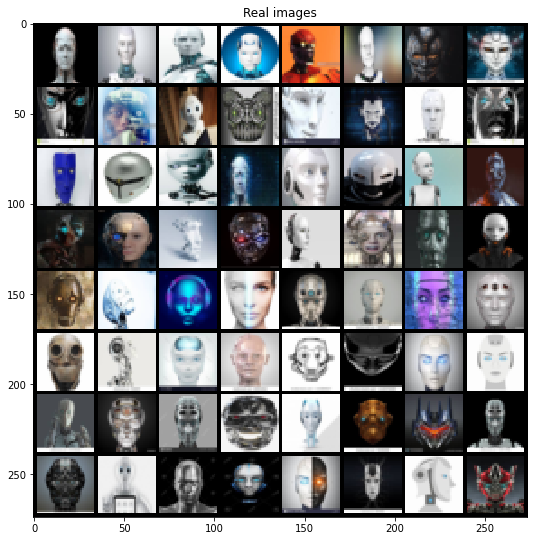

In [38]:
# to visualize the output of gen and the real images

z = torch.randn((64, 100, 1, 1)).to(device)
out = gen(z)
out_fake = torchvision.utils.make_grid(out, normalize=True)
out_fake = out_fake.cpu().detach()

import matplotlib.pyplot as plt
np_fake_img = out_fake.permute(1,2,0)
fig1 = plt.figure(figsize=(20,20)) # create a 5 x 5 figure 
ax1 = fig1.add_subplot(211)
ax1.imshow(np_fake_img, interpolation='none')
ax1.set_title('Fake images')


img_loder = DataLoader(dataset, batch_size=64, shuffle=True)
real_imgs, _ = next(iter(img_loder))
#real_imgs.permute(1,2,0)
real_imgs_grid = torchvision.utils.make_grid(real_imgs, normalize=True)
np_real_imgs = real_imgs_grid.permute(1,2,0)
fig2 = plt.figure(figsize=(20,20))
ax2 = fig2.add_subplot(212)
ax2.imshow(np_real_imgs, interpolation='none')
ax2.set_title('Real images')

plt.show()

In [35]:
torch.save(gen.state_dict(), 'wgan_gen.pt')
torch.save(critic.state_dict(),'wgan_critic.pt')